<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>Melody Extraction and Separation</h1> 
</div>

<br/>

<p>
Following Section 8.2 and Section 8.2.3.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we cover in this notebook two related problems referred to as <strong>melody extraction</strong> and <strong>melody separation</strong>. The overall approach was suggested by Salamon and Gómez:
    
<ul>
<li><span style="color:black">
Justin Salamon and Emilia Gómez: <strong>Melody Extraction from Polyphonic Music Signals using Pitch Contour Characteristics.</strong> IEEE Transactions on Audio, Speech, and Language Processing, 20 (2012), pp. 1759&ndash;1770.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_SalamonG12_MelodyExtraction_TASLP.txt"> Bibtex </a>
</span></li>
</ul>    
</p> 


## Melody

When asked to describe a specific song, we are often able to sing or hum the main melody. In general terms, a **melody** may be defined as a linear succession of musical tones expressing a particular musical idea. Because of the special arrangement of tones, a melody is perceived as a coherent entity, which gets stuck in a listener's head as the most memorable element of a song. As the original Greek term **melōidía** (meaning "singing" or "chanting") implies, a melody is often performed by a human voice. Oftentimes, the melody constitutes the leading element in a composition, appearing in the foreground, while the accompaniment is in the background. Sometimes melody and accompaniment may even be played on a single instrument such as a guitar or a piano. In any case, the melody typically stands out in one way or another. For example, the melody often comprises the higher notes in a musical composition, while the accompaniment consists of the lower notes. Or the melody is played by some instrument with a characteristic timbre . In some performances, the notes of a melody may feature easily discernible time&ndash;frequency patterns such as **vibrato**, **tremolo**, or **glissando** (i.e., a continuous glide from one pitch to another). As with many other concepts in music processing, the notion of melody remains rather vague. In music processing, one often considers a restricted scenario. In the [FMP notebook on F0 tracking](../C8/C8S2_FundFreqTracking.html), for example, we make the following simplifying assumptions:

* First, we consider the scenario where the music is given in the form of an audio recording (and not as a symbolic music representation).
* Second, rather than estimating a sequence of notes, we represent the melody by a sequence of F0-values that correspond to the notes' pitches.
* Third,  we restrict ourselves to music where the melody is predominant (e.g., being performed by a lead singer or a lead instrument). 
* Forth, we assume that there is only one melody line at a time, which can be associated to a single sound source.

## Melody Extraction

Based on these assumptions, the **melody extraction problem** can be regarded as the following signal processing task: Given a recording, the objective is to automatically estimate the sequence of **predominant F0-values** that correspond to the notes played by the lead voice or instrument. This is exactly the problem we discussed in the [FMP notebook on F0 tracking](../C8/C8S2_FundFreqTracking.html). The basic procedure can be summarized as follows:

* First, compute a [salience representation](../C8/C8S2_SalienceRepresentation.html).
* Then, derive the [trajectory](../C8/C8S2_FundFreqTracking.html) of predominant F0-values using suitable smoothness or score-informed constraints. 
* Also, as suggested by Salamon and Gómez, one may introduce other musical constraints, e.g.,  based on pitch contours. 

The melody extraction problem is challenging even in the restricted case that the simplifying assumptions are valid. 

* In music with many instruments playing simultaneously, it is hard to attribute specific time&ndash;frequency patterns to notes of individual instruments.
* Also, the presence of resonance and reverberation effects further increases the overlap of different sound sources. 
* Furthermore, even after a successful estimation of fundamental frequencies, one still has to determine which of the F0-values belong to the predominant melody and which are part of the accompaniment.

Continuing our [Freischütz example](../C8/C8S2_SalienceRepresentation.html), the following figure shows a spectrogram representation as well as the F0-trajectory of the melody performed by a soprano singer. Note the following: 

* The singer is not always active. This is also indicated by the activity pattern plotted below the spectrogram.

* At some time points, the spectral bin with the highest magnitude may belong to the accompaniment. This is one reason for errors in melody estimation. 

* Some of the higher harmonics may contain more energy than the fundamental frequency, which may lead to **octave errors** in melody estimation. 

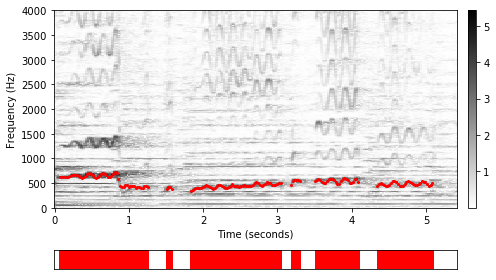

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy import ndimage
from scipy.interpolate import interp1d
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib import gridspec
import IPython.display as ipd
from numba import jit
import pandas as pd
from collections import OrderedDict

sys.path.append('..')
import libfmp.b
import libfmp.c3
import libfmp.c8

%matplotlib inline

def plot_STFT_F0_activity(Y, traj, figsize=(7,4), ylim = [0, 4000], cmap='gray_r'):
    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [10, 0.2],
                                        'height_ratios': [10, 1]}, figsize= figsize)    
    
    fig_im, ax_im, im = libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, 
                                            ax=[ax[0,0], ax[0,1]], title='', cmap=cmap);
    ax[0,0].set_ylim(ylim)
    traj_plot = traj[traj[:, 1] > 0, :]
    ax[0,0].plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='');
        
    # F0 activity
    activity = np.array(traj[:, 1] > 0).reshape(1, -1)
    im = ax[1,0].imshow(activity, aspect='auto', cmap='bwr', clim=[-1, 1])
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    ax[1,1].axis('off')
    plt.tight_layout()
    return fig, ax

# Load audio
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
ipd.Audio(x, rate=Fs)

# Computation of STFT
N = 2048
H = N//4
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
Y = np.log(1 + np.abs(X))
Fs_feature = Fs/H
T_coef = np.arange(X.shape[1]) / Fs_feature
freq_res = Fs / N
F_coef = np.arange(X.shape[0]) * freq_res
#F_coef = libfmp.c3.F_coef(np.arange(Y.shape[0]), Fs, N)

# Load F0 trajectory and and resample to fit to X
fn_traj = os.path.join('..', 'data', 'C8', 'FMP_C8_F10_Weber_Freischuetz-06_FreiDi-35-40_F0-user-Book.csv')
traj_df = libfmp.b.read_csv(fn_traj)
traj = traj_df.values
Fs_traj = 1/(traj[1,0]-traj[0,0])
traj_X_values = interp1d(traj[:,0], traj[:,1], kind='nearest', fill_value='extrapolate')(T_coef)
traj_X = np.hstack((T_coef[:,None], traj_X_values[:,None]))

# Visualization
figsize=(7,4)
ylim = [0, 4000]
fig, ax = plot_STFT_F0_activity(Y, traj_X, figsize=figsize, ylim=ylim)
plt.show()

# Sonification
soni_mono = libfmp.c8.sonify_trajectory_with_sinusoid(traj_X, len(x), Fs)
soni_stereo = np.vstack((x.reshape(1,-1), soni_mono.reshape(1,-1)))  # left: x, right: sonification
ipd.Audio(soni_stereo, rate=Fs)

## Melody Separation: Overall Idea

In our simplified scenario, the objective of **melody extraction** is to estimate the sequence of F0-values that correspond to the main melody. A related task is referred to as  **melody separation**, which aims at decomposing a music signal into a melody component that captures the main melodic voice and an accompaniment component that captures the remaining acoustic events. One application of melody separation is the automated generation of a **Karaoke version** for a given song, where the main melodic voice is to be removed from the song's original recording. More technically speaking, the objective of melody separation is to decompose a given signal $x$ into a melody component $x^\mathrm{Mel}$ and an accompaniment component $x^\mathrm{Acc}$ such that 

\begin{equation}
    x = x^\mathrm{Mel} + x^\mathrm{Acc}.
\end{equation}

One general approach is to first apply a melody extraction algorithm to derive the F0-trajectory of the main melody. Based on these **F0-values** and their **harmonics**, one can construct a **binary mask** for the melodic component, while the binary mask of the accompaniment is defined to be the complement. Using masking techniques as described in the [FMP notebook on HPS](../C8/C8S1_HPS.html) (see Section 8.1.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>), one then derives the two masked STFTs $\mathcal{X}^\mathrm{Mel}$ and $\mathcal{X}^\mathrm{Acc}$. From this, one obtains the signals $x^\mathrm{Mel}$ and $x^\mathrm{Acc}$ by applying [signal reconstruction techniques](../C8/C8S1_SignalReconstruction.html) (see Section 8.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>). We now implement this melody separation procedure and apply it to the Freischütz example. 

## Binary Mask

There are many ways to define a **binary mask** for a given F0-trajectory. Taking harmonics into account, we provide in the following code cell two variants. 

* In the first variant, one can specify a tolerance parameters `tol_bin` (given in frequency bins), which is used to define a frequency neighborhood of **fixed size** around each frequency bin.
* In the second variant, one can specify a tolerance parameters `tol_cents` (given in cents), which is used to define a neighborhood of **frequency-dependent size** around each frequency bin. More precisely, the neighborhood size increases linearly with the center frequency (so that it remains constant when measured in cents).

In the following figure, we show the binary masks for the melody (as well as their complements for the accompaniment) for both variants.

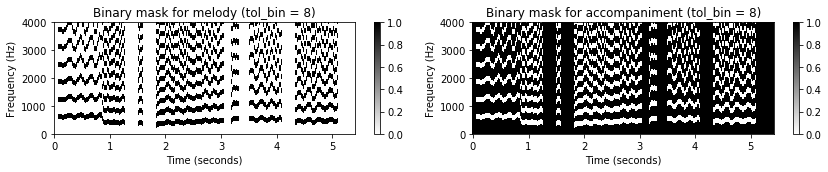

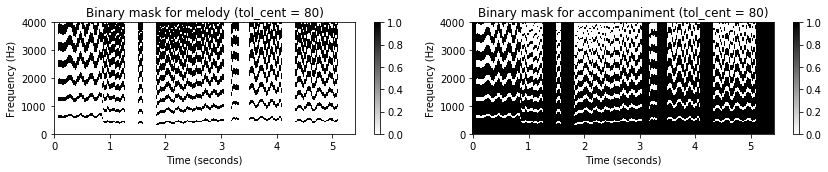

In [2]:
def convert_trajectory_to_mask_bin(traj, F_coef, n_harmonics=1, tol_bin=0):
    """Computes binary mask from F0 trajectory

    Notebook: C8/C8S2_MelodyExtractSep.ipynb

    Args:
        traj (np.ndarray): F0 trajectory (time in seconds in 1st column, frequency in Hz in 2nd column)
        F_coef (np.ndarray): Frequency axis
        n_harmonics (int): Number of harmonics (Default value = 1)
        tol_bin (int): Tolerance in frequency bins (Default value = 0)

    Returns:
        mask (np.ndarray): Binary mask
    """
    # Compute STFT bin for trajectory
    traj_bin = np.argmin(np.abs(F_coef[:, None] - traj[:, 1][None, :]), axis=0)

    K = len(F_coef)
    N = traj.shape[0]
    max_idx_harm = np.max([K, np.max(traj_bin)*n_harmonics])
    mask_pad = np.zeros((max_idx_harm.astype(int)+1, N))

    for h in range(n_harmonics):
        mask_pad[traj_bin*h, np.arange(N)] = 1
    mask = mask_pad[1:K+1, :]

    if tol_bin > 0:
        smooth_len = 2*tol_bin + 1
        mask = ndimage.filters.maximum_filter1d(mask, smooth_len, axis=0, mode='constant', cval=0, origin=0)

    return mask


def convert_trajectory_to_mask_cent(traj, F_coef, n_harmonics=1, tol_cent=0.0):
    """Computes binary mask from F0 trajectory

    Notebook: C8/C8S2_MelodyExtractSep.ipynb

    Args:
        traj (np.ndarray): F0 trajectory (time in seconds in 1st column, frequency in Hz in 2nd column)
        F_coef (np.ndarray): Frequency axis
        n_harmonics (int): Number of harmonics (Default value = 1)
        tol_cent (float): Tolerance in cents (Default value = 0.0)

    Returns:
        mask (np.ndarray): Binary mask
    """
    K = len(F_coef)
    N = traj.shape[0]
    mask = np.zeros((K, N))

    freq_res = F_coef[1] - F_coef[0]
    tol_factor = np.power(2, tol_cent/1200)
    F_coef_upper = F_coef * tol_factor
    F_coef_lower = F_coef / tol_factor
    F_coef_upper_bin = (np.ceil(F_coef_upper / freq_res)).astype(int)
    F_coef_upper_bin[F_coef_upper_bin > K-1] = K-1
    F_coef_lower_bin = (np.floor(F_coef_lower / freq_res)).astype(int)

    for n in range(N):
        for h in range(n_harmonics):
            freq = traj[n, 1] * (1 + h)
            freq_bin = np.round(freq / freq_res).astype(int)
            if freq_bin < K:
                idx_upper = F_coef_upper_bin[freq_bin]
                idx_lower = F_coef_lower_bin[freq_bin]
                mask[idx_lower:idx_upper+1, n] = 1
    return mask


figsize = (12, 2.5)

# Binary masks for melody and accompaniment using bins
tol_bin = 8
mask_mel_bin = convert_trajectory_to_mask_bin(traj_X, F_coef, 
                                              n_harmonics=30, tol_bin=tol_bin)
mask_acc_bin = np.ones(mask_mel_bin.shape) - mask_mel_bin

plt.figure(figsize=figsize)
ax = plt.subplot(121)
title = r'Binary mask for melody (tol_bin = %d)'%tol_bin
fig_im, ax_im, im = libfmp.b.plot_matrix(mask_mel_bin, Fs=Fs_feature, ax=[ax],
                                         Fs_F=1/freq_res, figsize=figsize, title=title);
plt.ylim(ylim);
ax = plt.subplot(122)
title=r'Binary mask for accompaniment (tol_bin = %d)'%tol_bin
fig, ax, im = libfmp.b.plot_matrix(mask_acc_bin, Fs=Fs_feature, ax=[ax], 
                                   Fs_F=1/freq_res, figsize=figsize, title=title);
plt.ylim(ylim);
plt.tight_layout()

# Binary masks for melody and accompaniment using cents
tol_cent = 80
mask_mel_cent = convert_trajectory_to_mask_cent(traj_X, F_coef, n_harmonics=30, tol_cent=tol_cent)
mask_acc_cent = np.ones(mask_mel_cent.shape) - mask_mel_cent

plt.figure(figsize=figsize)
ax = plt.subplot(121)
title=r'Binary mask for melody (tol_cent = %d)'%tol_cent
fig_im, ax_im, im = libfmp.b.plot_matrix(mask_mel_cent, Fs=Fs_feature, ax=[ax], 
                                         Fs_F=1/freq_res, figsize=figsize, title=title);
plt.ylim(ylim);
ax = plt.subplot(122)
title=r'Binary mask for accompaniment (tol_cent = %d)'%tol_cent
fig, ax, im = libfmp.b.plot_matrix(mask_acc_cent, Fs=Fs_feature, ax=[ax], 
                                   Fs_F=1/freq_res, figsize=figsize, title=title);
plt.ylim(ylim);
plt.tight_layout()

## Signal Reconstruction

Next, we construct the [masked STFTs](../C8/C8S1_HPS.html) $\mathcal{X}^\mathrm{Mel}$ and $\mathcal{X}^\mathrm{Acc}$ and the signals $x^\mathrm{Mel}$. From this, we obtain the time-domain signals $x^\mathrm{Acc}$ by applying [signal reconstruction techniques](../C8/C8S1_SignalReconstruction.html). Again, we present the results for both masking variants.

<!--This procedure is implemented in the following code example and applied to our Freischütz excerpt.-->

<!--<img src="../data/C8/FMP_C8_F18.png" width="600px" align="middle" alt="FMP_C8_F18">-->

Melody separation (tol_bin = 8)


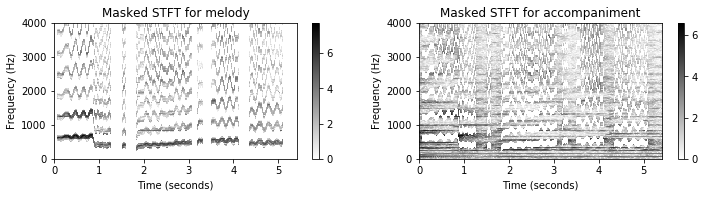

Melody separation (tol_cent = 80)


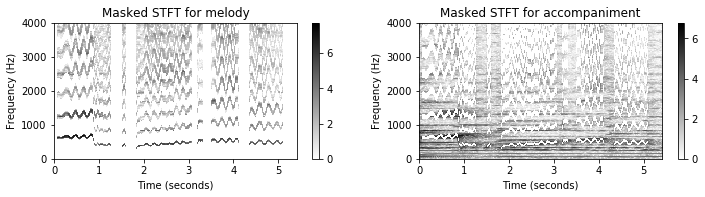

Melody separation (joint mask using "logical or" operator)


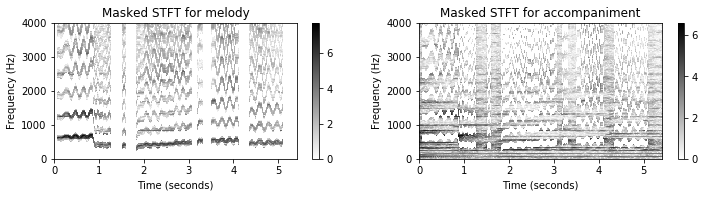

In [3]:
#def display_signals_mel_acc(x_mel, x_acc, header_mel, header_acc):
#    html_x_mel = libfmp.c8.generate_audio_tag_html_list([x_mel], Fs=Fs, width='350')
#    html_x_acc = libfmp.c8.generate_audio_tag_html_list([x_acc], Fs=Fs, width='350')
#
#    pd.set_option('display.max_colwidth', None)    
#    df = pd.DataFrame(OrderedDict([
#        (header_mel, html_x_mel),
#        (header_acc, html_x_acc)]))
#    ipd.display(ipd.HTML(df.to_html(escape=False, header=True, index=False)))
   
def compute_plot_display_mel_acc(Fs, X, N, H, mask_mel, figsize=figsize):
    mask_acc = np.ones(mask_mel.shape) - mask_mel
    X_mel = X * mask_mel
    X_acc = X * mask_acc
    x_mel = librosa.istft(X_mel, hop_length=H, win_length=N, window='hann', center=True, length=x.size)
    x_acc = librosa.istft(X_acc, hop_length=H, win_length=N, window='hann', center=True, length=x.size)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(121)
    fig_im, ax_im, im = libfmp.b.plot_matrix(np.log(1+10 * np.abs(X_mel)), Fs=Fs_feature, ax=[ax], Fs_F=1/freq_res, figsize=figsize, 
                     title='Masked STFT for melody');
    plt.ylim(ylim);
    ax = plt.subplot(122)
    fig, ax, im = libfmp.b.plot_matrix(np.log(1+10 * np.abs(X_acc)), Fs=Fs_feature, ax=[ax], Fs_F=1/freq_res, figsize=figsize, 
                     title='Masked STFT for accompaniment');
    plt.ylim(ylim);    
    plt.show()
    libfmp.b.audio_player_list([x_mel, x_acc], [Fs, Fs], width=350, 
         columns=['Reconstructed signal for melody', 'Reconstructed signal for accompaniment'])

print('Melody separation (tol_bin = %d)'%tol_bin)
compute_plot_display_mel_acc(Fs, X, N, H, mask_mel_bin, figsize=figsize)

print('Melody separation (tol_cent = %d)'%tol_cent)
compute_plot_display_mel_acc(Fs, X, N, H, mask_mel_cent, figsize=figsize)

mask_mel_joint = np.logical_or(mask_mel_bin, mask_mel_cent)
print('Melody separation (joint mask using "logical or" operator)')
compute_plot_display_mel_acc(Fs, X, N, H, mask_mel_joint, figsize=figsize)

## Example: Stop Messing With Me (Bornemark)

Assuming that an F0-trajectory is given for the melody, the overall procedure for melody-accompaniment separation is summarized in the following code cell. As an example, we use excerpt of the song ["Stop Messing With Me" by Sven Bornemark](../C8/C8S2_FundFreqTracking.html), where the melody is performed by a male singer. As input to the separation procedure, we use the constraint-based F0-trajectory as computed at the end of the [FMP notebook on fundamental frequency tracking](../C8/C8S2_FundFreqTracking.html). Besides presenting the separated components signals, we also provide the ideal melody track and accompaniment track, which are also available for the song. 

<!--The following figure shows a spectrogram representation of only the singing voice, where the F0-trajectory of the melody is clearly visible. However, note that some of the higher harmonics may contain more energy than the fundamental frequency.-->
<!--<img src="../data/C8/FMP_C8_F11a.png" width="300px" align="left" alt="FMP_C8_F11a">
<br clear="all" />-->

<audio style="width: 300px;" src="../data/C8/FMP_C8_Audio_Bornemark_StopMessingWithMe-Excerpt_SoundCloud_mix.mp3" type="audio/mpeg" controls="controls"></audio>

In [4]:
def separate_melody_accompaniment(x, Fs, N, H, traj, n_harmonics=10, tol_cent=50.0):
    """F0-based melody-accompaniement separation

    Notebook: C8/C8S2_MelodyExtractSep.ipynb

    Args:
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling frequency
        N (int): Window size in samples
        H (int): Hopsize in samples
        traj (np.ndarray): F0 traj (time in seconds in 1st column, frequency in Hz in 2nd column)
        n_harmonics (int): Number of harmonics (Default value = 10)
        tol_cent (float): Tolerance in cents (Default value = 50.0)

    Returns:
        x_mel (np.ndarray): Reconstructed audio signal for melody
        x_acc (np.ndarray): Reconstructed audio signal for accompaniement
    """
    # Compute STFT
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
    Fs_feature = Fs / H
    T_coef = np.arange(X.shape[1]) / Fs_feature
    freq_res = Fs / N
    F_coef = np.arange(X.shape[0]) * freq_res

    # Adjust trajectory
    traj_X_values = interp1d(traj[:, 0], traj[:, 1], kind='nearest', fill_value='extrapolate')(T_coef)
    traj_X = np.hstack((T_coef[:, None], traj_X_values[:, None, ]))

    # Compute binary masks
    mask_mel = convert_trajectory_to_mask_cent(traj_X, F_coef, n_harmonics=n_harmonics, tol_cent=tol_cent)
    mask_acc = np.ones(mask_mel.shape) - mask_mel

    # Compute masked STFTs
    X_mel = X * mask_mel
    X_acc = X * mask_acc

    # Reconstruct signals
    x_mel = librosa.istft(X_mel, hop_length=H, win_length=N, window='hann', center=True, length=x.size)
    x_acc = librosa.istft(X_acc, hop_length=H, win_length=N, window='hann', center=True, length=x.size)

    return x_mel, x_acc

# Load audio
fn_wav = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Bornemark_StopMessingWithMe-Excerpt_SoundCloud_mix.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
x_duration = len(x)/Fs

fn_wav_track_mel = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Bornemark_StopMessingWithMe-Excerpt_SoundCloud_vocals.wav')
x_track_mel, Fs = librosa.load(fn_wav_track_mel, sr=Fs)

fn_wav_track_acc = os.path.join('..', 'data', 'C8', 'FMP_C8_Audio_Bornemark_StopMessingWithMe-Excerpt_SoundCloud_accomp.wav')
x_track_acc, Fs = librosa.load(fn_wav_track_acc, sr=Fs)


# Read constraint regions
constraint_region_df = libfmp.b.read_csv(os.path.join('..', 'data', 'C8', 'FMP_C8_F11_SvenBornemark_StopMessingWithMe_CR.csv'))
constraint_region = constraint_region_df.values

# Compute trajectory
traj, Z, T_coef, F_coef_hertz, F_coef_cents = libfmp.c8.compute_traj_from_audio(x, Fs=Fs, 
                                        constraint_region=constraint_region, gamma=0.1)

N = 2048
H = N//4
x_mel, x_acc = separate_melody_accompaniment(x, Fs=Fs, N=N, H=H, traj=traj, n_harmonics=30, tol_cent=50)

libfmp.b.audio_player_list([x_mel, x_acc], [Fs, Fs], width=350, 
    columns=['Reconstructed signal for melody', 'Reconstructed signal for accompaniment'])

libfmp.b.audio_player_list([x_track_mel, x_track_acc], [Fs, Fs], width=350, 
    columns=['Ideal signal for melody', 'Ideal signal for melody for accompaniment'])

## Further Notes

In this notebook, we presented a procedure for decomposing a music recording into a melody component and an accompaniment component, where we assumed that the F0-trajectory of the melody is given. Obviously, in this simplistic voice separation scenario, the requirements on the accuracy of the extracted F0-values are very high.  Furthermore, nonharmonic properties of the singing voice such as fricative and plosive components (coming from consonants) have not been considered. Modeling and separating such nonharmonic components from sound mixtures generally constitutes a hard research question. Recent approaches for **singing voice separation** (or, more generally speaking, **source separation** approaches) are mostly based on deep learning techniques using large amounts of training examples. Here are some useful links:

* [Demixing Professionally Produced Music (SiSEC 2016)](https://www.sisec17.audiolabs-erlangen.de/): This website presents the results of the Music (MUS) task of the sixth community-based Signal Separation Evaluation Campaign (SiSEC 2016). It shows objective and subjective results of 100 full-track songs of different styles separated into five components (vocals, accompaniment, drums, bass and other). 
* [Community-Based Signal Separation Evaluation Campaign (SiSEC 2018)](http://sisec.inria.fr/)
* [MedleyDB: A Dataset of Multitrack Audio for Music Research](https://medleydb.weebly.com/)
* [Freischütz Digital Multitrack Dataset](https://www.audiolabs-erlangen.de/resources/MIR/FreiDi/MultitrackDataset/)
	




<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/rosenzweig">Sebastian Rosenzweig</a>.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>